In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
tf.__version__

'2.15.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Computer Vision Masterclass/Datasets/cat_dog_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

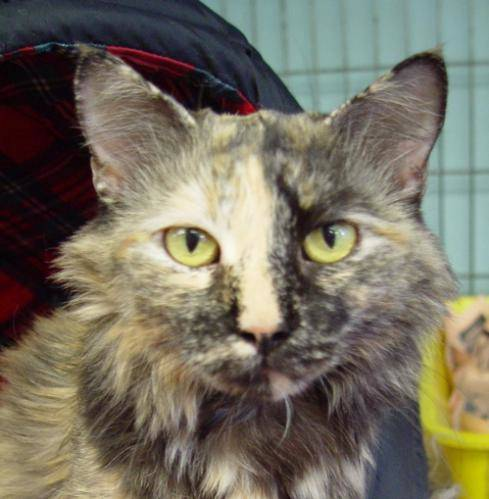

In [4]:
load_img('/content/cat_dog_2/training_set/cat/cat.10.jpg')

## Train and Test set

In [5]:
train_generator=ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = train_generator.flow_from_directory('/content/cat_dog_2/training_set',
                                                        target_size = (128, 128),
                                                        batch_size = 128,
                                                        class_mode = 'binary',
                                                        shuffle = True)

Found 4000 images belonging to 2 classes.


In [6]:
train_dataset.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [7]:
train_dataset.class_indices

{'cat': 0, 'dog': 1}

In [8]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/cat_dog_2/test_set',
                                                     target_size = (128, 128),
                                                     batch_size = 1,
                                                     class_mode = 'binary',
                                                     shuffle = False)

Found 1000 images belonging to 2 classes.


In [9]:
train_dataset.classes,train_dataset.class_indices

(array([0, 0, 0, ..., 1, 1, 1], dtype=int32), {'cat': 0, 'dog': 1})

In [45]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, #include top is false meaning we will include the dense layers ourself
                                            input_shape =(128, 128, 3))

In [46]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [47]:
len(base_model.layers)

154

In [48]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7fb706a15f60> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706a2a590> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706b88e80> True
<keras.src.layers.activation.relu.ReLU object at 0x7fb706c44e80> True
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fb7782932b0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706a5a170> True
<keras.src.layers.activation.relu.ReLU object at 0x7fb706e414e0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706d3e0b0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706e6a950> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706c440a0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706af2ec0> True
<keras.src.layers.activation.relu.ReLU object at 0x7f

In [49]:
base_model.trainable=True

In [50]:
for layer in base_model.layers:
  layer.trainable=False

In [51]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7fb706a15f60> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706a2a590> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706b88e80> False
<keras.src.layers.activation.relu.ReLU object at 0x7fb706c44e80> False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fb7782932b0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706a5a170> False
<keras.src.layers.activation.relu.ReLU object at 0x7fb706e414e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706d3e0b0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706e6a950> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706c440a0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706af2ec0> False
<keras.src.layers.activation.relu.ReLU obj

In [52]:
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [53]:
(1280+1)//2

640

In [54]:
head_model=base_model.output
head_model=head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model=head_model = Dense(units=640,activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model=head_model = Dense(units=640,activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(1, activation='sigmoid')(head_model)

In [55]:
network=Model(inputs=base_model.input,outputs=head_model)

In [56]:
network.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

In [57]:
network.compile(loss = 'binary_crossentropy', optimizer='Adam',
                metrics = ['accuracy'])

In [59]:
history = network.fit(train_dataset, epochs=5)

Epoch 1/5
32/32 [==============================] - 20s 620ms/step - loss: 0.1028 - accuracy: 0.9572
Epoch 2/5
32/32 [==============================] - 21s 670ms/step - loss: 0.0827 - accuracy: 0.9682
Epoch 3/5
32/32 [==============================] - 20s 618ms/step - loss: 0.0698 - accuracy: 0.9710
Epoch 4/5
32/32 [==============================] - 22s 679ms/step - loss: 0.0610 - accuracy: 0.9758
Epoch 5/5
32/32 [==============================] - 20s 623ms/step - loss: 0.0616 - accuracy: 0.9778


In [60]:
#wow

In [61]:
# Approach 1 (all pixels): 0.50
# Approach 2 (CNN): 0.72
# Approach 3 (Transfer learning): 0.96
network.evaluate(test_dataset)

1000/1000 [==============================] - 10s 9ms/step - loss: 0.0956 - accuracy: 0.9630


[0.09562738984823227, 0.9629999995231628]

## Fine Tuning

In [62]:
base_model.trainable = True

In [63]:
len(base_model.layers)

154

In [64]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7fb706a15f60> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706a2a590> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706b88e80> True
<keras.src.layers.activation.relu.ReLU object at 0x7fb706c44e80> True
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fb7782932b0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706a5a170> True
<keras.src.layers.activation.relu.ReLU object at 0x7fb706e414e0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706d3e0b0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706e6a950> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706c440a0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706af2ec0> True
<keras.src.layers.activation.relu.ReLU object at 0x7f

In [65]:
fine_tuning_at = 100

In [66]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

In [67]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7fb706a15f60> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706a2a590> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706b88e80> False
<keras.src.layers.activation.relu.ReLU object at 0x7fb706c44e80> False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fb7782932b0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706a5a170> False
<keras.src.layers.activation.relu.ReLU object at 0x7fb706e414e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706d3e0b0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706e6a950> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fb706c440a0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb706af2ec0> False
<keras.src.layers.activation.relu.ReLU obj

In [68]:
network.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics = ['accuracy'])

In [69]:
history = network.fit(train_dataset, epochs=5)

Epoch 1/5
32/32 [==============================] - 33s 603ms/step - loss: 0.1866 - accuracy: 0.9362
Epoch 2/5
32/32 [==============================] - 22s 661ms/step - loss: 0.0965 - accuracy: 0.9672
Epoch 3/5
32/32 [==============================] - 20s 629ms/step - loss: 0.0565 - accuracy: 0.9800
Epoch 4/5
32/32 [==============================] - 22s 679ms/step - loss: 0.0680 - accuracy: 0.9775
Epoch 5/5
32/32 [==============================] - 20s 625ms/step - loss: 0.0536 - accuracy: 0.9808


In [70]:
predictions = network.predict(test_dataset)
predictions

1000/1000 [==============================] - 9s 8ms/step


array([[2.70686564e-06],
       [1.83884680e-01],
       [3.48458416e-04],
       [1.00000000e+00],
       [2.57275776e-12],
       [9.55142621e-16],
       [1.27548692e-05],
       [2.25088215e-07],
       [2.09595341e-09],
       [9.77800250e-01],
       [1.98189691e-13],
       [5.34117238e-12],
       [1.65187529e-07],
       [2.38817721e-09],
       [1.00000000e+00],
       [1.00000000e+00],
       [2.81057197e-07],
       [8.69022302e-12],
       [9.46455598e-01],
       [3.59317873e-08],
       [5.30578402e-13],
       [5.66340086e-14],
       [2.73325737e-03],
       [9.09241891e-08],
       [2.01383511e-11],
       [7.34966074e-04],
       [7.39429765e-07],
       [1.00000000e+00],
       [9.99999881e-01],
       [1.76256932e-02],
       [1.40965531e-05],
       [1.00000000e+00],
       [1.00000000e+00],
       [6.35706678e-12],
       [2.51188764e-10],
       [1.00000000e+00],
       [9.99999642e-01],
       [5.97837371e-08],
       [2.61562741e-06],
       [2.17797673e-08],


In [71]:
predictions = (predictions > 0.5)
predictions

array([[False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [

In [72]:
# Approach 1 (all pixels): 0.50
# Approach 2 (CNN): 0.72
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.845

In [73]:
network.evaluate(test_dataset)

1000/1000 [==============================] - 10s 8ms/step - loss: 3.5783 - accuracy: 0.8450


[3.5782763957977295, 0.8450000286102295]

In [74]:
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)


In [75]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

<ipython-input-75-32bf80f9a744>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, '/content/weights.hdf5')
